In [1]:
import torch
import pandas as pd
import numpy as np
from torch.distributions import constraints
from scipy import stats
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro.poutine.runtime import effectful
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS
import matplotlib.pyplot as plt
from tqdm import tqdm

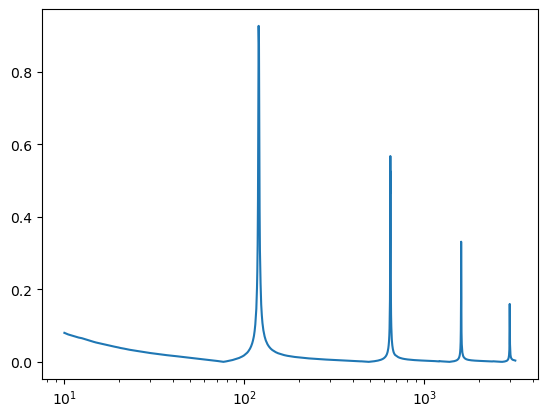

In [2]:
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values
plt.plot(freq, mobility)
plt.xscale("log")

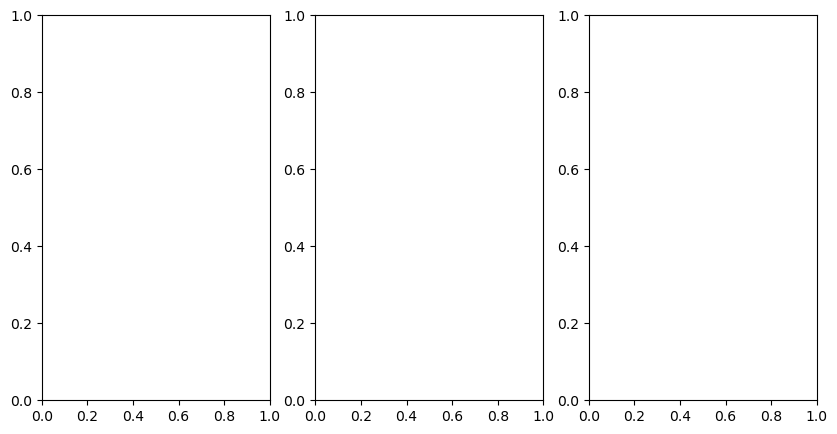

In [3]:
fig, axes = plt.subplots(figsize=(10,5), ncols=3, nrows=1)
goal = mobility[np.logical_and(mobility>0.2, mobility<0.75)]
goalFreq = freq[np.logical_and(mobility>0.2, mobility<0.75)]

In [4]:

E_theo=8e10
E_var_init = 5e9
rho_theo=8000.0
rho_var_init = 250
eta_theo=0.00505
eta_var_init = 0.006

def mobilityFuncModel(self, E_dist, rho_dist, eta_dist, freq):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E = E_dist
    rho = rho_dist
    eta = eta_dist
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*torch.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = torch.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = torch.cos(complex_kl)*torch.cosh(complex_kl) + 1
    D_l = torch.cos(complex_kl)*torch.sinh(complex_kl) + torch.sin(complex_kl)*torch.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*torch.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)

In [5]:
E_values = []
eta_values = []
rho_values = []
priorType = "Gaussian"
def model(x, y_obs):
    global E_theo
    global E_var_init 
    global rho_theo
    global rho_var_init
    global eta_theo
    global eta_var_init
    # Density definition
    rho_mean = pyro.param("rho_mean", rho_theo)
    rho = pyro.sample("rho", dist.Normal(rho_mean, rho_var_init))
    # Damping loss factor definition
    eta_mean = pyro.param("eta_mean", eta_theo)
    eta = pyro.sample("eta", dist.Normal(eta_mean, eta_var_init))
    # Young's modulus definition
    E_mean = pyro.param("E_mean", E_theo)
    E = pyro.sample("E", dist.Normal(E_mean, E_var_init))
    
    #rho, eta, E = normalization(rho, eta, E, rho_std, eta_std, E_var_init)
    #rho, eta, E = normalization(rho*rho_std+rho_mean, eta*eta_std+eta_mean, E*E_std+E_mean, rho_std, eta_std, E_var_init)

    E_values[step] = E
    eta_values[step] = eta
    rho_values[step] = rho

    y_values = self.mobilityFuncModel(E, rho, eta, x)
    with pyro.plate("data", len(y_obs)):
        y = pyro.sample("y", dist.Normal(20*torch.log10(y_values), 0.001), obs=20*torch.log10(y_obs))
    return y

In [6]:
data = goal
pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500)
mcmc.run(data)
samples = mcmc.get_samples()


Warmup:   0%|          | 0/1000 [00:00, ?it/s]

TypeError: model() missing 2 required positional arguments: 'x' and 'y_obs'